https://github.com/yanchick/Practice-ML-DEV грузить сюда

Задача №6: Классификация глиомы мозга

#Описание задачи

Глиомы являются самыми распространенными первичными опухолями головного мозга. Их можно классифицировать как LGG (низкой степени злокачестввенности) или GBM (глиобластома мультформа) в зависимости от гистологических и имиджинговых критериев. Клинические и молекулярные/мутационные факторы также играют важную роль в процессе классификации. Молекулярные тесты дороги и помогают точно диагностировать пациентов с глиомой. В этом датасете рассматриваются наиболее часто мутировавшие 20 генов и 3 клинические характеристики из проектов по глиоме мозга TCGA-LGG и TCGA-GBM. Задача предсказания заключается в определении, является ли пациент LGG или GBM на основе имеющихся клинических и молекулярных/мутационных характеристик.

Ваша задача - создать модель машинного обучения для классификации пациентов с глиомой мозга на LGG и GBM на основе предоставленных клинических и молекулярных характеристик.

#ML задачи
•	провести входной анализ данных (EDA)

•	определить метрики для оценки эффективности модели

•	сформировть baseline-модель

•	предложить улучшенную модель и вывести ее в продакшн

#Описание датасета

Датасет включает информацию о 20 молекулярных признаках (каждый из которых может быть мутированным или wildtype в зависимости от TCGA Case_ID) и 3 клинических признаках (касающихся демографии пациента). Всего записей - 839.



Grade - целевая переменная

In [1]:
!pip install catboost -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 9.0 MB/s eta 0:00:00


In [2]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.colors import LinearSegmentedColormap

import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_val_predict

from catboost import CatBoostClassifier, cv, Pool

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score

%matplotlib inline

In [4]:
%cd /content/gdrive/MyDrive/1 семестр/Практикум по разработке ML сервисов/

/content/gdrive/MyDrive/1 семестр/Практикум по разработке ML сервисов


In [5]:
df = pd.read_csv('TCGA_GBM_LGG_Mutations_all.csv')

In [6]:
df.head()

,Grade,Project,Case_ID,Gender,Age_at_diagnosis,Primary_Diagnosis,Race,IDH1,TP53,ATRX,...,FUBP1,RB1,NOTCH1,BCOR,CSMD3,SMARCA4,GRIN2A,IDH2,FAT4,PDGFRA
0,LGG,TCGA-LGG,TCGA-DU-8164,Male,51 years 108 days,"Oligodendroglioma, NOS",white,MUTATED,NOT_MUTATED,NOT_MUTATED,...,MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED
1,LGG,TCGA-LGG,TCGA-QH-A6CY,Male,38 years 261 days,Mixed glioma,white,MUTATED,NOT_MUTATED,NOT_MUTATED,...,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED
2,LGG,TCGA-LGG,TCGA-HW-A5KM,Male,35 years 62 days,"Astrocytoma, NOS",white,MUTATED,MUTATED,MUTATED,...,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED
3,LGG,TCGA-LGG,TCGA-E1-A7YE,Female,32 years 283 days,"Astrocytoma, anaplastic",white,MUTATED,MUTATED,MUTATED,...,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,MUTATED,NOT_MUTATED
4,LGG,TCGA-LGG,TCGA-S9-A6WG,Male,31 years 187 days,"Astrocytoma, anaplastic",white,MUTATED,MUTATED,MUTATED,...,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED


In [7]:
df.columns

Index(['Grade', 'Project', 'Case_ID', 'Gender', 'Age_at_diagnosis',
       'Primary_Diagnosis', 'Race', 'IDH1', 'TP53', 'ATRX', 'PTEN', 'EGFR',
       'CIC', 'MUC16', 'PIK3CA', 'NF1', 'PIK3R1', 'FUBP1', 'RB1', 'NOTCH1',
       'BCOR', 'CSMD3', 'SMARCA4', 'GRIN2A', 'IDH2', 'FAT4', 'PDGFRA'],
      dtype='object')

#Отредачим колонки

In [8]:
df = df.drop('Project', axis=1)
df = df.drop('Race', axis=1)
df = df.drop('Primary_Diagnosis', axis=1)
df = df.drop('Case_ID', axis=1)

In [9]:
df.head()

,Grade,Gender,Age_at_diagnosis,IDH1,TP53,ATRX,PTEN,EGFR,CIC,MUC16,...,FUBP1,RB1,NOTCH1,BCOR,CSMD3,SMARCA4,GRIN2A,IDH2,FAT4,PDGFRA
0,LGG,Male,51 years 108 days,MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,...,MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED
1,LGG,Male,38 years 261 days,MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,MUTATED,NOT_MUTATED,...,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED
2,LGG,Male,35 years 62 days,MUTATED,MUTATED,MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,...,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED
3,LGG,Female,32 years 283 days,MUTATED,MUTATED,MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,MUTATED,...,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,MUTATED,NOT_MUTATED
4,LGG,Male,31 years 187 days,MUTATED,MUTATED,MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,...,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED


In [10]:
df = df.drop(df[df['Gender'] == '--'].index)
df = df.drop(df[df['Age_at_diagnosis'] == '--'].index)

In [11]:
df['Age_at_diagnosis'] = df['Age_at_diagnosis'].str.split().str[0]
df['Age_at_diagnosis'] = df['Age_at_diagnosis'].astype(int)

In [12]:
df

,Grade,Gender,Age_at_diagnosis,IDH1,TP53,ATRX,PTEN,EGFR,CIC,MUC16,...,FUBP1,RB1,NOTCH1,BCOR,CSMD3,SMARCA4,GRIN2A,IDH2,FAT4,PDGFRA
0,LGG,Male,51,MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,...,MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED
1,LGG,Male,38,MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,MUTATED,NOT_MUTATED,...,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED
2,LGG,Male,35,MUTATED,MUTATED,MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,...,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED
3,LGG,Female,32,MUTATED,MUTATED,MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,MUTATED,...,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,MUTATED,NOT_MUTATED
4,LGG,Male,31,MUTATED,MUTATED,MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,...,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
857,GBM,Female,77,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,...,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED
858,GBM,Male,85,NOT_MUTATED,MUTATED,NOT_MUTATED,MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,...,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED
859,GBM,Female,77,NOT_MUTATED,MUTATED,NOT_MUTATED,MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,...,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED
860,GBM,Male,63,NOT_MUTATED,MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,MUTATED,...,NOT_MUTATED,MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED


0 - NOT_MUTATED

1 - MUTATED

In [13]:
columns_to_replace = ['IDH1', 'TP53', 'ATRX', 'PTEN',
       'EGFR', 'CIC', 'MUC16', 'PIK3CA', 'NF1', 'PIK3R1', 'FUBP1', 'RB1',
       'NOTCH1', 'BCOR', 'CSMD3', 'SMARCA4', 'GRIN2A', 'IDH2', 'FAT4',
       'PDGFRA']

In [14]:
df[columns_to_replace] = df[columns_to_replace].replace({'MUTATED': 1, 'NOT_MUTATED': 0}).astype(int)

In [15]:
df["Gender"] = df["Gender"].replace({'Male': 1, 'Female': 0}).astype(int)

In [16]:
df.Age_at_diagnosis.unique()

array([51, 38, 35, 32, 31, 33, 44, 87, 54, 52, 47, 34, 40, 53, 41, 43, 37,
       25, 66, 56, 65, 45, 50, 27, 46, 24, 29, 62, 36, 70, 48, 20, 57, 59,
       67, 58, 74, 61, 42, 55, 39, 30, 60, 64, 49, 69, 14, 63, 71, 73, 19,
       28, 26, 23, 17, 21, 68, 22, 75, 72, 79, 76, 82, 81, 89, 77, 80, 85,
       78, 86, 84, 83, 88])

In [17]:
bins = [18, 35, 50, 65, float('inf')]  # Замените этот список на свои интервалы

# Определение меток для возрастных групп
labels = ['19-35', '36-50', '51-65', '66+']

# Применение метода cut для создания нового столбца с возрастными группами
df['Age_at_diagnosis'] = pd.cut(df['Age_at_diagnosis'], bins=bins, labels=labels, right=False)

In [18]:
df

,Grade,Gender,Age_at_diagnosis,IDH1,TP53,ATRX,PTEN,EGFR,CIC,MUC16,...,FUBP1,RB1,NOTCH1,BCOR,CSMD3,SMARCA4,GRIN2A,IDH2,FAT4,PDGFRA
0,LGG,1,51-65,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,LGG,1,36-50,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,LGG,1,36-50,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,LGG,0,19-35,1,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
4,LGG,1,19-35,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
857,GBM,0,66+,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
858,GBM,1,66+,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
859,GBM,0,66+,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
860,GBM,1,51-65,0,1,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0


In [19]:
df.rename(columns={'Age_at_diagnosis': 'Age_group'}, inplace=True)

In [20]:
df = pd.get_dummies(df, columns=['Age_group'], prefix='Age_group')

In [21]:
columns = df.columns.tolist()
new_order = columns[:2] + columns[-4:] + columns[2:-4]
df = df[new_order]

In [22]:
df["Grade"] = df["Grade"].replace({'GBM': 1, 'LGG': 0}).astype(int)

In [23]:
df

,Grade,Gender,Age_group_19-35,Age_group_36-50,Age_group_51-65,Age_group_66+,IDH1,TP53,ATRX,PTEN,...,FUBP1,RB1,NOTCH1,BCOR,CSMD3,SMARCA4,GRIN2A,IDH2,FAT4,PDGFRA
0,0,1,0,0,1,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,0,1,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,1,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,1,0
4,0,1,1,0,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
857,1,0,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
858,1,1,0,0,0,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
859,1,0,0,0,0,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
860,1,1,0,0,1,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0


#EDA

In [24]:
df.shape

(857, 26)

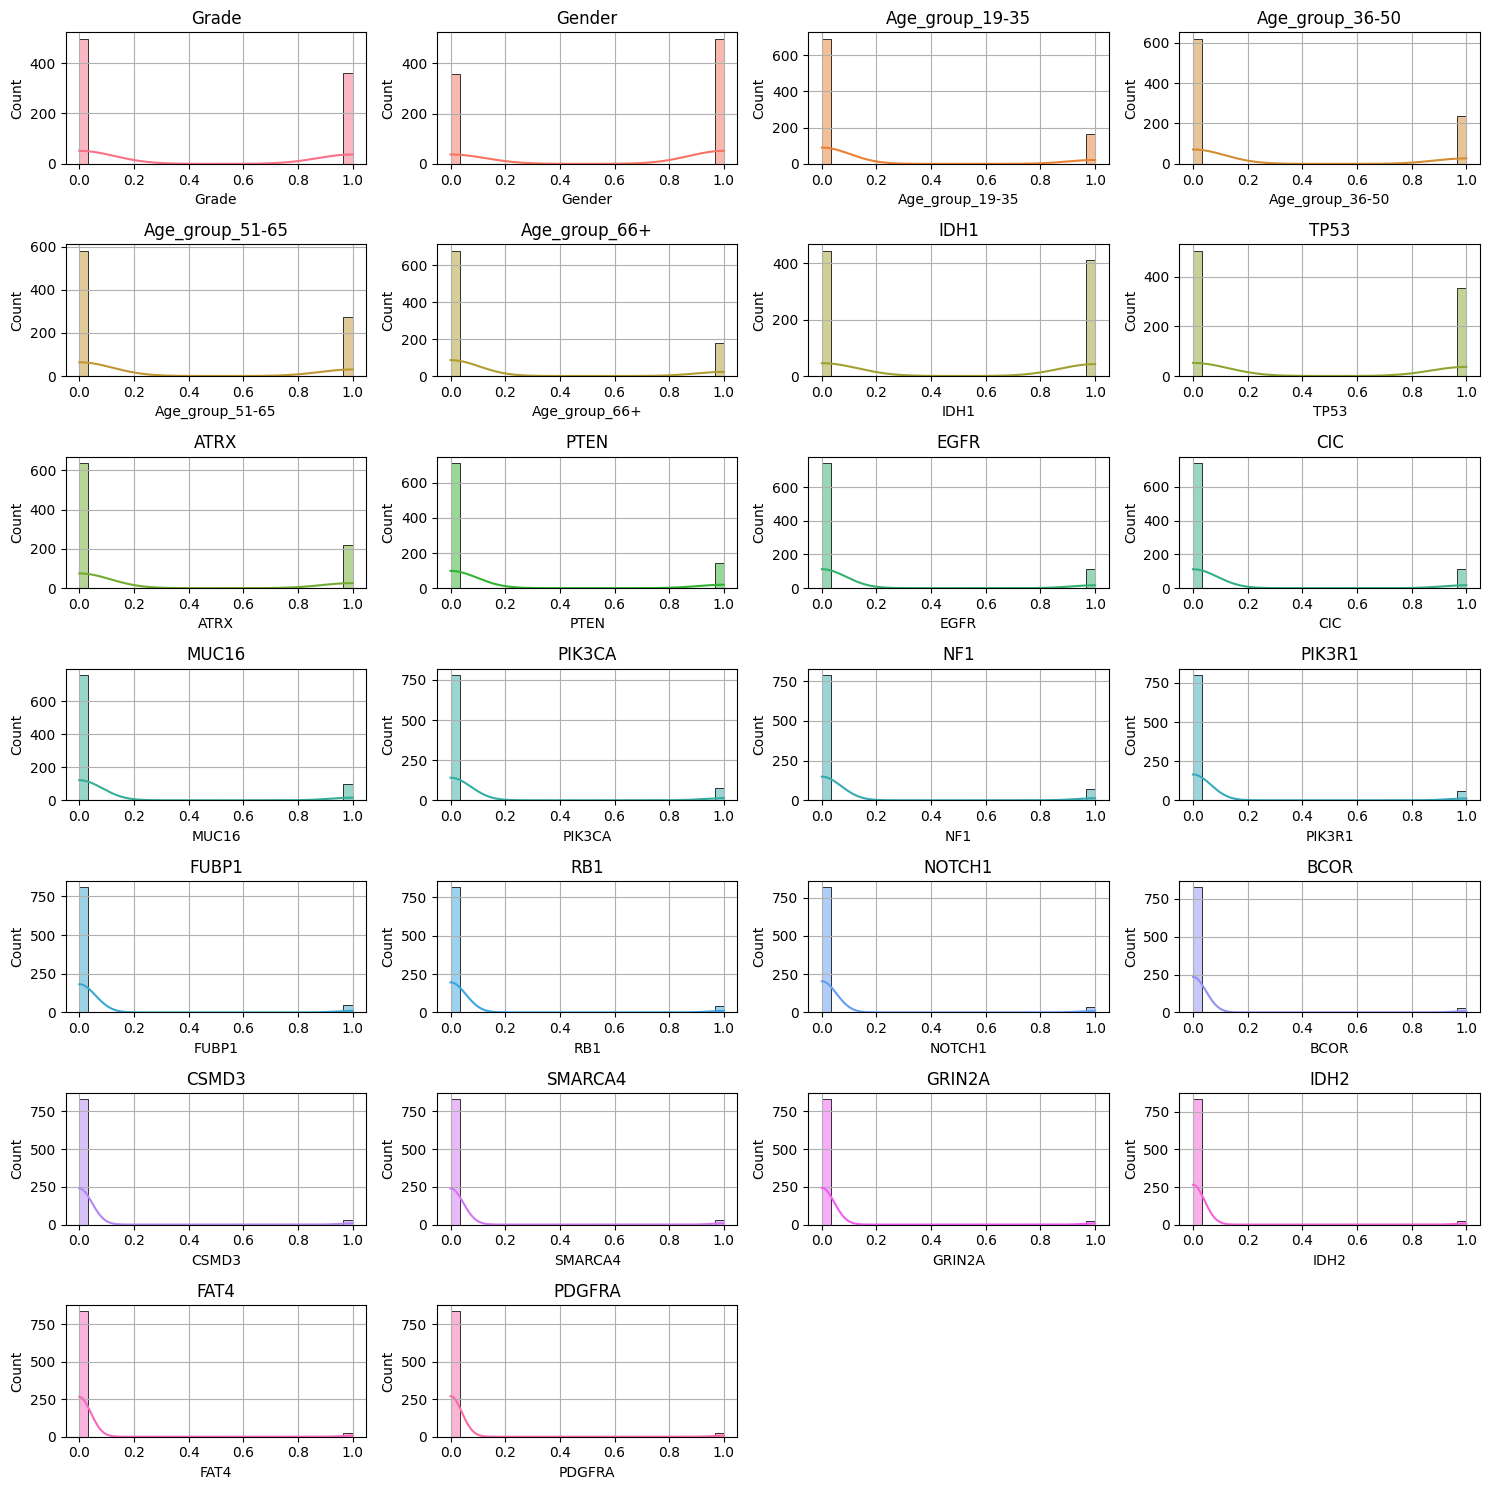

In [25]:
columns = 4
rows = (len(df.columns) + columns - 1) // columns

# Создаем подложку для графиков
fig, axs = plt.subplots(rows, columns, figsize=(15, 15))

# Определение уникальных цветов для каждого столбца
colors = sns.color_palette("husl", len(df.columns))

# Распределение для каждого столбца с использованием Seaborn
for i, column in enumerate(df.columns):
    ax = axs[i // columns, i % columns]
    sns.histplot(df[column], ax=ax, bins=30, kde=True, color=colors[i])
    ax.set_title(column)
    ax.grid(True)

# Убираем пустые подграфики, если количество столбцов не делится на columns
for i in range(len(df.columns), rows * columns):
    fig.delaxes(axs.flatten()[i])

# Улучшаем макет
plt.tight_layout()
plt.show()

Кастомная тепловая карта

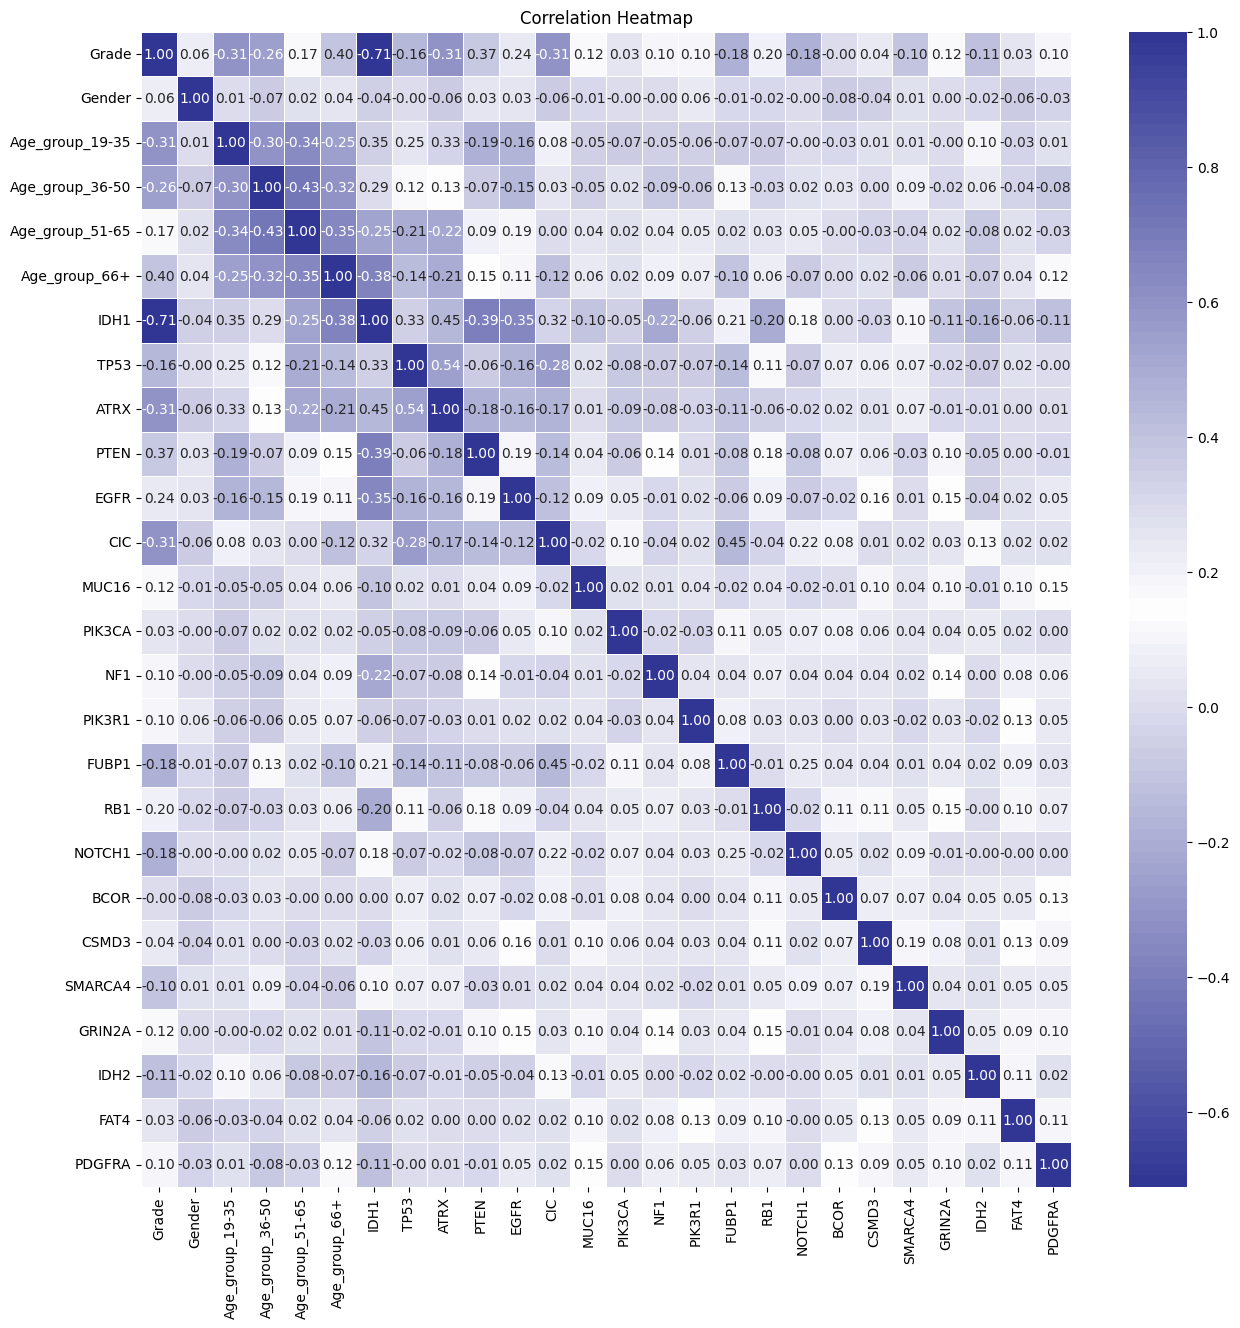

In [26]:
correlation_matrix = df.corr()

# Определяем цвета для создания плавных переходов
colors = ['#313695', 'white', '#313695']  # Пример цветов
n_bins = 100  # Количество оттенков

# Создаем собственную цветовую карту с плавными переходами
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', sns.color_palette(colors, as_cmap=True), N=n_bins)

# Указываем, что хотим рисовать графики в том же окне
%matplotlib inline

# Создаем тепловую карту с кастомными цветами и плавными переходами
plt.figure(figsize=(15, 15))
sns.heatmap(correlation_matrix, annot=True, cmap=custom_cmap, fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap')
plt.show()

#Обучение

In [27]:
X = df.drop('Grade', axis=1)
y = df['Grade']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

##Логистическая регрессия

Так как у нас есть сильный дизбаланс классов, мы будем использовать кросс-валидацию с StratifiedKFold

###Обучение

In [28]:
model = LogisticRegressionCV(scoring='f1_macro', cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), max_iter=1000)

In [29]:
model = LogisticRegressionCV(cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), scoring='f1', max_iter=1000) #Cs=[0.001, 0.01, 0.1, 1, 10],
model.fit(X_train, y_train)
print(f'Optimal C: {model.C_[0]}')

Optimal C: 0.3593813663804626


###Проверка на train

In [30]:
train_predictions = cross_val_predict(model, X_train, y_train, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42))

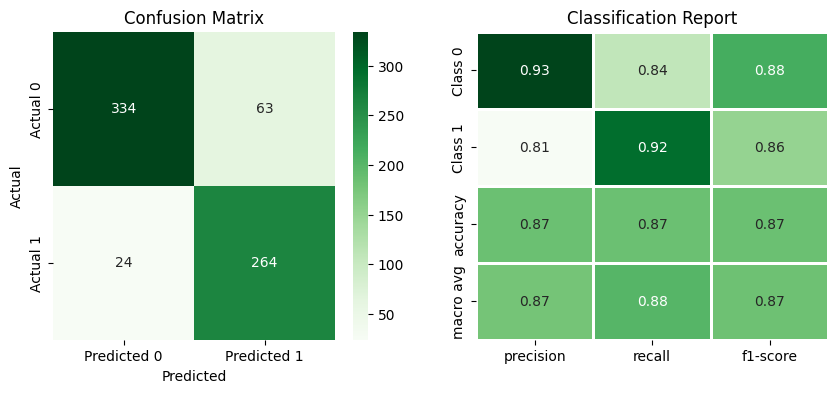

In [31]:
conf_matrix_train = confusion_matrix(y_train, train_predictions)
class_rep_train = classification_report(y_train, train_predictions, target_names=['Class 0', 'Class 1'], output_dict=True)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sns.heatmap(conf_matrix_train, annot=True, fmt='d', cmap='Greens', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.subplot(1, 2, 2)
sns.heatmap(pd.DataFrame(class_rep_train).iloc[:-1, :-1].T, annot=True, cmap='Greens', fmt='.2f', linewidths=1, linecolor='white', cbar=False)
plt.title('Classification Report')
plt.show()

###Проверка на test

In [32]:
test_predictions = model.predict(X_test)

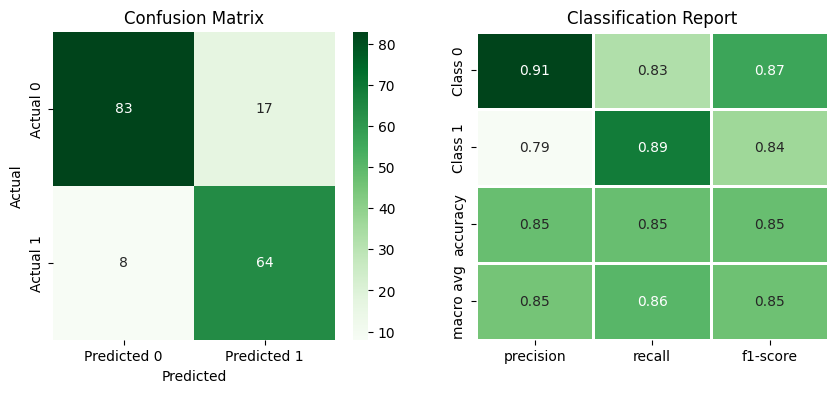

In [33]:
conf_matrix_train = confusion_matrix(y_test, test_predictions)
class_rep_train = classification_report(y_test, test_predictions, target_names=['Class 0', 'Class 1'], output_dict=True)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sns.heatmap(conf_matrix_train, annot=True, fmt='d', cmap='Greens', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.subplot(1, 2, 2)
sns.heatmap(pd.DataFrame(class_rep_train).iloc[:-1, :-1].T, annot=True, cmap='Greens', fmt='.2f', linewidths=1, linecolor='white', cbar=False)
plt.title('Classification Report')
plt.show()

##CatBoost

In [34]:
params = {
    'iterations': 1000,
    'learning_rate': 0.05,
    'depth': 6,
    'loss_function': 'MultiClass',  # Используйте 'Logloss' для бинарной классификации
    'eval_metric': 'TotalF1',
    'random_seed': 42,
    'logging_level': 'Silent',
}

In [35]:
catboost_model = CatBoostClassifier(**params)
train_pool = Pool(X_train, y_train)

In [36]:
cv_results = cv(pool=train_pool, params=params, fold_count=5, stratified=True, seed=42)

In [37]:
print(f'Среднее значение метрики TotalF1 на кросс-валидации: {np.max(cv_results["test-TotalF1-mean"])}')

Среднее значение метрики TotalF1 на кросс-валидации: 0.875197052594795


In [38]:
catboost_model = CatBoostClassifier(**params)
catboost_model.fit(train_pool)

###Проверка на train

In [39]:
train_pool = Pool(X_train)
train_predictions = catboost_model.predict(train_pool)

In [40]:
f1 = f1_score(y_train, train_predictions, average='weighted')

In [41]:
print(f'F1-метрика на тестовых данных: {f1}')

F1-метрика на тестовых данных: 0.9330407915314508


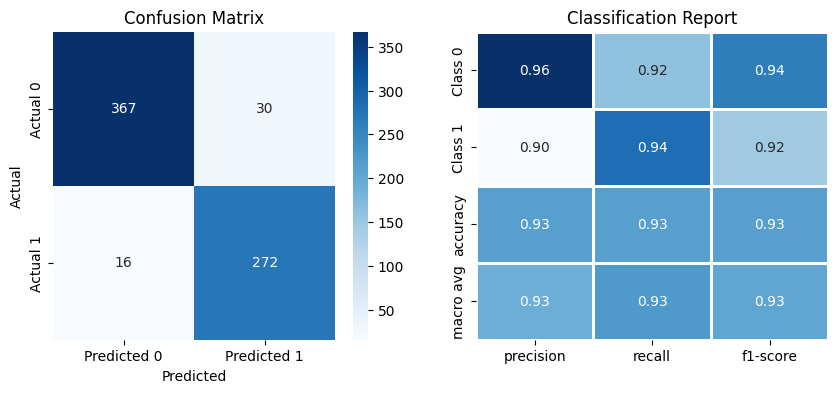

In [42]:
conf_matrix_train = confusion_matrix(y_train, train_predictions)
class_rep_train = classification_report(y_train, train_predictions, target_names=['Class 0', 'Class 1'], output_dict=True)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sns.heatmap(conf_matrix_train, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.subplot(1, 2, 2)
sns.heatmap(pd.DataFrame(class_rep_train).iloc[:-1, :-1].T, annot=True, cmap='Blues', fmt='.2f', linewidths=1, linecolor='white', cbar=False)
plt.title('Classification Report')
plt.show()

###Проверка на test

In [43]:
test_pool = Pool(X_test)
test_predictions = catboost_model.predict(test_pool)

In [44]:
f1 = f1_score(y_test, test_predictions, average='weighted')

In [45]:
print(f'F1-метрика на тестовых данных: {f1}')

F1-метрика на тестовых данных: 0.8438150610980817


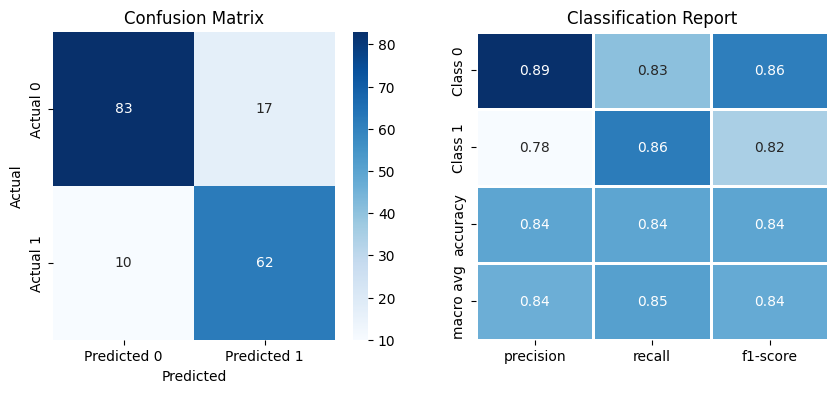

In [46]:
conf_matrix_train = confusion_matrix(y_test, test_predictions)
class_rep_train = classification_report(y_test, test_predictions, target_names=['Class 0', 'Class 1'], output_dict=True)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sns.heatmap(conf_matrix_train, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.subplot(1, 2, 2)
sns.heatmap(pd.DataFrame(class_rep_train).iloc[:-1, :-1].T, annot=True, cmap='Blues', fmt='.2f', linewidths=1, linecolor='white', cbar=False)
plt.title('Classification Report')
plt.show()

#RandomForest

In [47]:
random_forest_model = RandomForestClassifier(random_state=42)

In [48]:
stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [49]:
cv_scores = cross_val_score(random_forest_model, X_train, y_train, cv=stratified_cv, scoring='f1')

In [50]:
print(f"Средняя оценка на кросс-валидации: {np.mean(cv_scores)}")

Средняя оценка на кросс-валидации: 0.8243564509119459


In [51]:
random_forest_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

###Проверка на train

In [52]:
y_pred = random_forest_model.predict(X_train)

In [53]:
f1 = f1_score(y_train, y_pred, average='weighted')

In [54]:
print(f"Точность на тестовом наборе данных: {f1}")

Точность на тестовом наборе данных: 0.9345295581063234


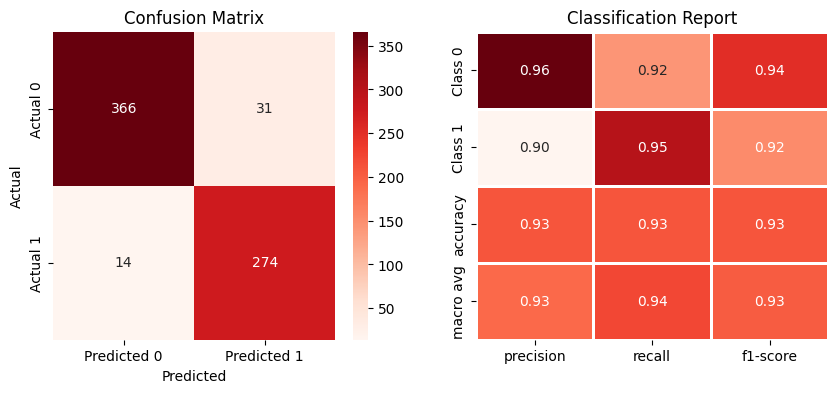

In [55]:
conf_matrix_train = confusion_matrix(y_train, y_pred)
class_rep_train = classification_report(y_train, y_pred, target_names=['Class 0', 'Class 1'], output_dict=True)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sns.heatmap(conf_matrix_train, annot=True, fmt='d', cmap='Reds', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.subplot(1, 2, 2)
sns.heatmap(pd.DataFrame(class_rep_train).iloc[:-1, :-1].T, annot=True, cmap='Reds', fmt='.2f', linewidths=1, linecolor='white', cbar=False)
plt.title('Classification Report')
plt.show()

###Проверка на test

In [56]:
y_pred = random_forest_model.predict(X_test)

In [57]:
f1 = f1_score(y_test, y_pred, average='weighted')

In [58]:
print(f"Точность на тестовом наборе данных: {f1}")

Точность на тестовом наборе данных: 0.8552264550391598


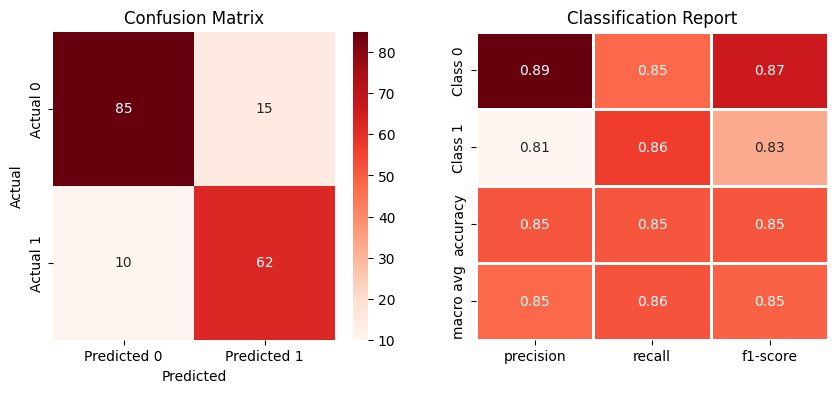

In [59]:
conf_matrix_train = confusion_matrix(y_test, y_pred)
class_rep_train = classification_report(y_test, y_pred, target_names=['Class 0', 'Class 1'], output_dict=True)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sns.heatmap(conf_matrix_train, annot=True, fmt='d', cmap='Reds', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.subplot(1, 2, 2)
sns.heatmap(pd.DataFrame(class_rep_train).iloc[:-1, :-1].T, annot=True, cmap='Reds', fmt='.2f', linewidths=1, linecolor='white', cbar=False)
plt.title('Classification Report')
plt.show()